In [1]:
!chmod 600 /content/kaggle.json

In [2]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d idhamozi/indonesian-sign-language-bisindo

indonesian-sign-language-bisindo.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_file = zipfile.ZipFile('/content/indonesian-sign-language-bisindo.zip')
zip_file.extractall('/tmp/')

In [4]:
import tensorflow as tf

print(len(tf.config.list_physical_devices('GPU')))

1


In [5]:
#Set Parameter
batch_size = 32     # set ukuran size
img_height = 224    # untuk set panjang image
img_width = 224    # untuk set panjang image

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('/tmp/Dataset BISINDO/datatrain')

test_dir = Path('/tmp/Dataset BISINDO/datatest')


# Get the filepaths and labels for the training data
train_filepaths = list(train_dir.glob(r'**/*.JPG'))
train_labels = [path.parent.name for path in train_filepaths]

# Get the filepaths and labels for the test data
test_filepaths = list(test_dir.glob(r'**/*.JPG'))
test_labels = [path.parent.name for path in test_filepaths]

# Create a DataFrame
df_train = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
df_test = pd.DataFrame({'Filepath': test_filepaths, 'Label': test_labels})

print("Number of images in df_train:", len(df_train))
print("Number of labels in df_train:", len(df_train['Label'].unique()))
print("Number of images in df_test:", len(df_test))
print("Number of labels in df_test:", len(df_test['Label'].unique()))
print("Classes in df_train:", df_train['Label'].unique())
print("Classes in df_test:", df_test['Label'].unique())

Number of images in df_train: 1727
Number of labels in df_train: 27
Number of images in df_test: 432
Number of labels in df_test: 27
Classes in df_train: ['R' 'U' 'Y' 'X' 'L' 'J' 'NOTHING' 'A' 'C' 'E' 'S' 'N' 'B' 'Z' 'D' 'H' 'M'
 'O' 'Q' 'G' 'V' 'W' 'F' 'K' 'T' 'I' 'P']
Classes in df_test: ['R' 'U' 'Y' 'X' 'L' 'J' 'NOTHING' 'A' 'C' 'E' 'S' 'N' 'B' 'Z' 'D' 'H' 'M'
 'O' 'Q' 'G' 'V' 'W' 'F' 'K' 'T' 'I' 'P']


In [7]:
df_train.head(10)

,Filepath,Label
0,/tmp/Dataset BISINDO/datatrain/R/IMG_0319.JPG,R
1,/tmp/Dataset BISINDO/datatrain/R/IMG_0322.JPG,R
2,/tmp/Dataset BISINDO/datatrain/R/IMG_1830.JPG,R
3,/tmp/Dataset BISINDO/datatrain/R/IMG_0332.JPG,R
4,/tmp/Dataset BISINDO/datatrain/R/IMG_0307.JPG,R
5,/tmp/Dataset BISINDO/datatrain/R/IMG_0327.JPG,R
6,/tmp/Dataset BISINDO/datatrain/R/IMG_1836.JPG,R
7,/tmp/Dataset BISINDO/datatrain/R/IMG_2058.JPG,R
8,/tmp/Dataset BISINDO/datatrain/R/IMG_2055.JPG,R
9,/tmp/Dataset BISINDO/datatrain/R/IMG_0328.JPG,R


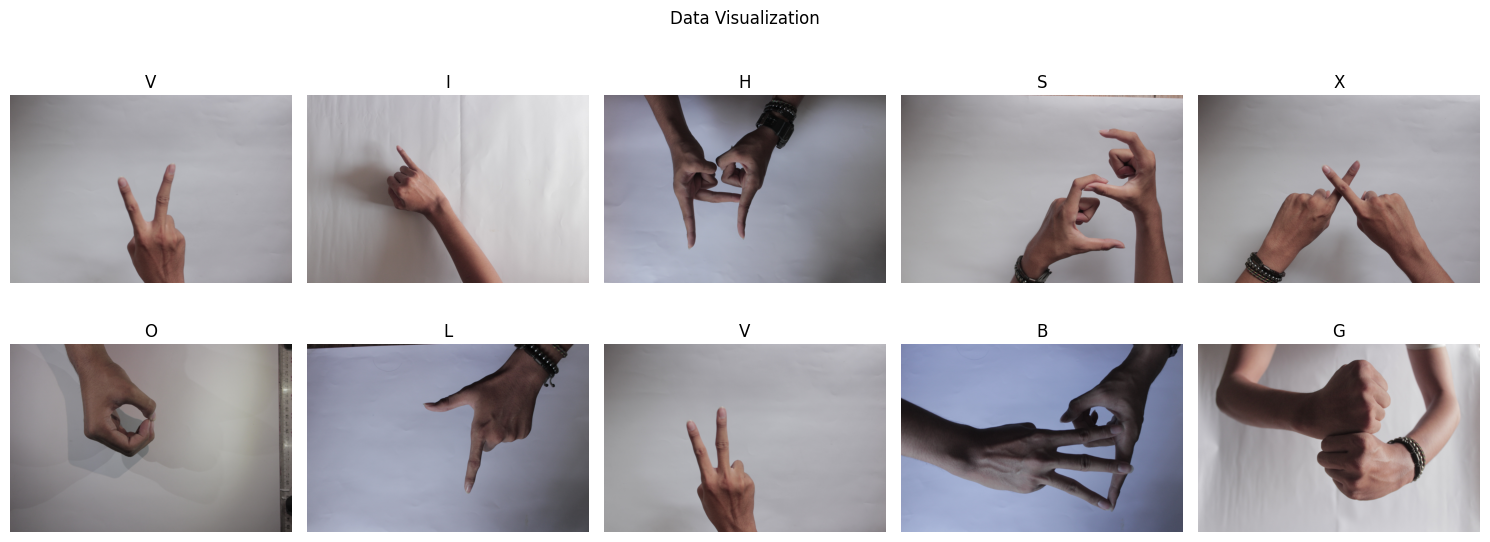

In [8]:
# Create a figure with subplots for visualization
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Visualization')

# Iterate over the train dataset and plot the images with labels
for i, (_, row) in enumerate(df_train.sample(5).iterrows()):
    image_path = row['Filepath']
    label = row['Label']
    image = plt.imread(str(image_path))
    axs[0, i].imshow(image)
    axs[0, i].set_title(label)
    axs[0, i].axis('off')

# Iterate over the test dataset and plot the images with labels
for i, (_, row) in enumerate(df_test.sample(5).iterrows()):
    image_path = row['Filepath']
    label = row['Label']
    image = plt.imread(str(image_path))
    axs[1, i].imshow(image)
    axs[1, i].set_title(label)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    weights = 'imagenet',
    input_shape = (img_width, img_height, 3),
    include_top = False,
    pooling = 'avg'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# See Pre Trained Model Summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [11]:
from tensorflow.keras import layers
from tensorflow.keras import Model



num_class = len(df_train['Label'].unique())

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(num_class, activation = 'softmax')(x)

# Re-Create model
model = Model(inputs = pre_trained_model.input, outputs = x)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image data generator parameters for augmentation or preprocessing
train_generator = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

train_datagen = train_generator.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = ImageDataGenerator(rescale=1/255)

val_datagen = test_generator.flow_from_directory(test_dir,
                                                 target_size=(img_height, img_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')



Found 1727 images belonging to 27 classes.
Found 432 images belonging to 27 classes.


In [13]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps = 20, decay_rate = 0.98, staircase = True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience = 10, restore_best_weights = True
)

In [14]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate = lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

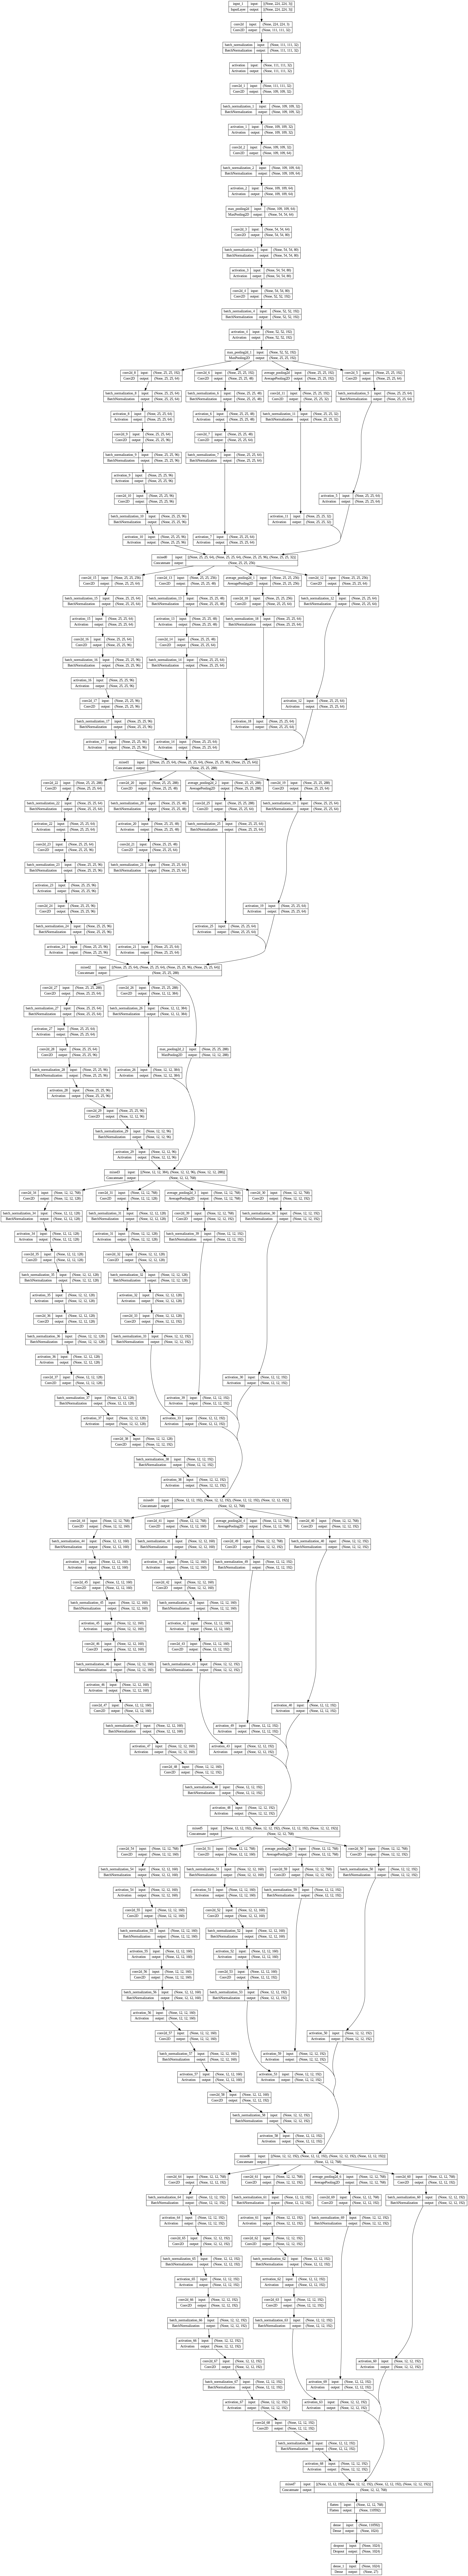

In [16]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='model60.png', show_shapes=True)

In [17]:
# Melatih model
history = model.fit(
    train_datagen,
    steps_per_epoch=54,
    epochs=100,
    validation_data=val_datagen,
    validation_steps= 14,
    verbose=2,
    callbacks=early_stopping_cb
)

Epoch 1/100
54/54 - 162s - loss: 2.3056 - accuracy: 0.3955 - val_loss: 1.1257 - val_accuracy: 0.7407 - 162s/epoch - 3s/step
Epoch 2/100
54/54 - 138s - loss: 0.9432 - accuracy: 0.7296 - val_loss: 0.4407 - val_accuracy: 0.8727 - 138s/epoch - 3s/step
Epoch 3/100
54/54 - 156s - loss: 0.5282 - accuracy: 0.8523 - val_loss: 0.2623 - val_accuracy: 0.9028 - 156s/epoch - 3s/step
Epoch 4/100
54/54 - 137s - loss: 0.3682 - accuracy: 0.8958 - val_loss: 0.1657 - val_accuracy: 0.9491 - 137s/epoch - 3s/step
Epoch 5/100
54/54 - 137s - loss: 0.2733 - accuracy: 0.9270 - val_loss: 0.1286 - val_accuracy: 0.9606 - 137s/epoch - 3s/step
Epoch 6/100
54/54 - 137s - loss: 0.2003 - accuracy: 0.9456 - val_loss: 0.1709 - val_accuracy: 0.9352 - 137s/epoch - 3s/step
Epoch 7/100
54/54 - 155s - loss: 0.1968 - accuracy: 0.9508 - val_loss: 0.1171 - val_accuracy: 0.9468 - 155s/epoch - 3s/step
Epoch 8/100
54/54 - 137s - loss: 0.1509 - accuracy: 0.9653 - val_loss: 0.1114 - val_accuracy: 0.9583 - 137s/epoch - 3s/step
Epoch 9/

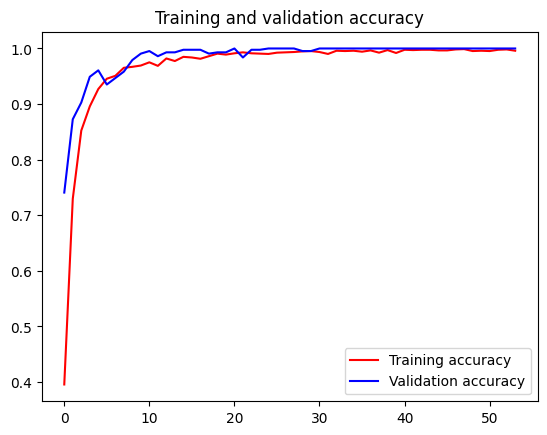

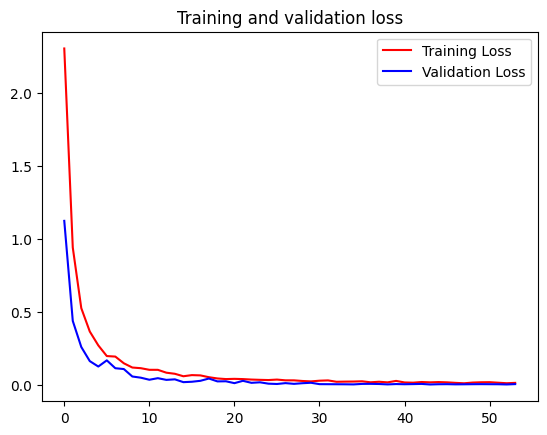

In [18]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Specify the path to save the model
model_path = "my_model/model.h5"

# Save the model
model.save(model_path)

# Print a message to confirm the save
print("Model saved at:", model_path)

Model saved at: my_model/model.h5


In [20]:
# Predict the label of the test_images
pred = model.predict(val_datagen)
pred = np.argmax(pred,axis=1)

# Map the label
labels =  train_datagen.class_indices
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in val_datagen.classes]

14/14 [==============================] - 28s 2s/step


In [21]:
labels.items()

dict_items([(0, 'A'), (1, 'B'), (2, 'C'), (3, 'D'), (4, 'E'), (5, 'F'), (6, 'G'), (7, 'H'), (8, 'I'), (9, 'J'), (10, 'K'), (11, 'L'), (12, 'M'), (13, 'N'), (14, 'NOTHING'), (15, 'O'), (16, 'P'), (17, 'Q'), (18, 'R'), (19, 'S'), (20, 'T'), (21, 'U'), (22, 'V'), (23, 'W'), (24, 'X'), (25, 'Y'), (26, 'Z')])

In [22]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 4.17%


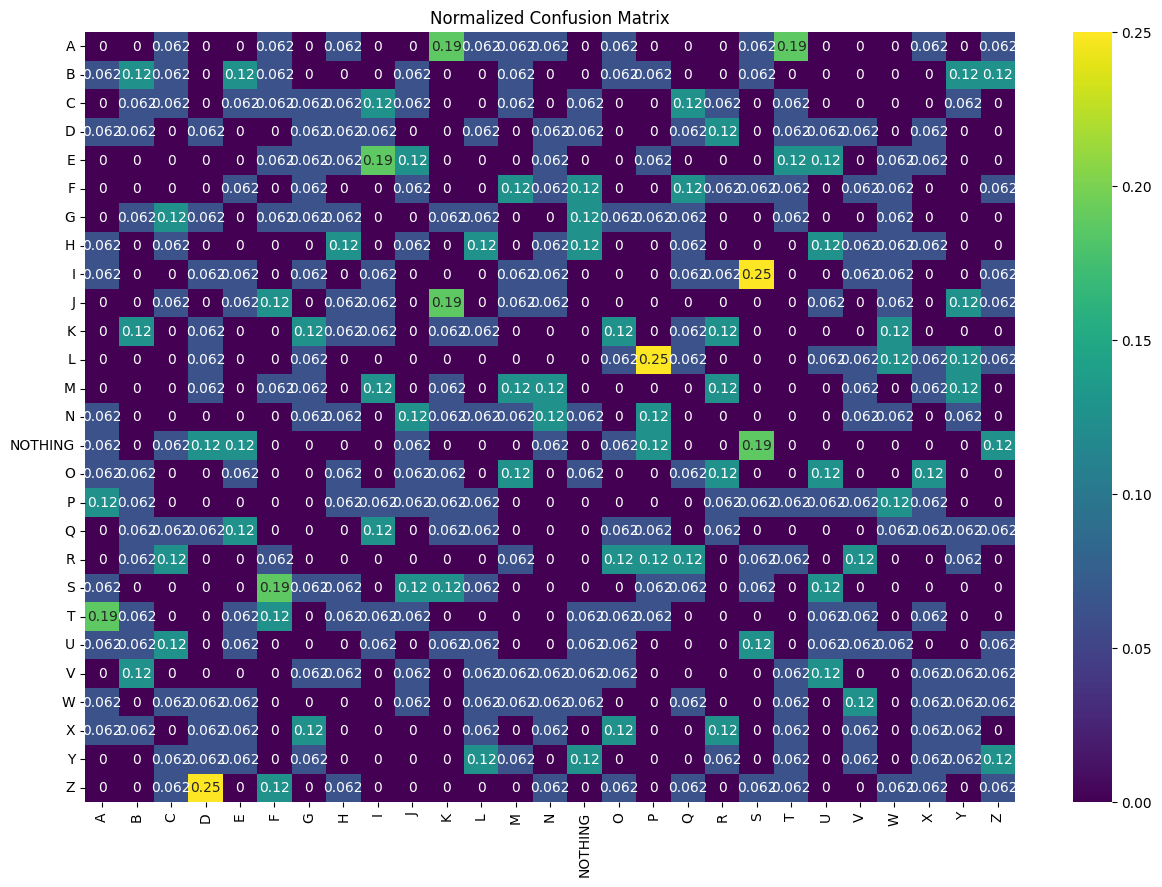

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            cmap="viridis",
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()